### Aim of anlysis
After viewing all forests in the world and characteristics of tropical dry forests. I want to perform analysis on the <b>Southern New Guinea freshwater swamp forest</b>

In [1]:
from shapely.geometry import mapping
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import rioxarray as rxr
import earthpy as et
import rasterio
import geopandas as gpd
import warnings
warnings.filterwarnings('ignore')

In [2]:
class Read():
    def __init__(self, url, columns = None):
        self.url = url
        self.columns = columns
        
    def retrieve_data(self):
        self.req = requests.get(self.url)
        self.req = str(self.req.text)

    def wrangle(self, online = False, change_columns = False, new_columns = None, replace_values = False,
               column_to_replace= None, replacing_values = None):
        if online:
            self.url = self.req
        self.df = gpd.read_file(self.url)
        if change_columns:
            self.df = self.df[self.columns]
            self.df.columns = new_columns
        self.df = self.df.replace(['n/a', 'Unknown'], np.nan)
        self.df.columns = self.df.columns.str.lower()
        if replace_values:
            self.df[column_to_replace] = self.df[column_to_replace].replace(replacing_values)
        self.df['centroid'] = self.df.geometry.centroid
        self.df.crs = {'init' :'epsg:4326'}
        return self.df

In [20]:
def plot_within(data, column, title, ncol):
    ax = data.plot(column = column,  figsize= (20, 8), legend = True, cmap = 'winter',
                        legend_kwds = {'ncol': ncol, 'loc' : 'center', 'bbox_to_anchor': (1.2, 0.5)})
    fav_forest.plot(ax = ax, color = 'brown')
    plt.title(title);

In [4]:
columns = ['CONTINENT','NAME_LONG', 'SUBREGION', 'geometry']
new_columns = ['continent', 'country', 'SUBREGION', 'geometry']
world_data = Read('zip://data/ne_110m_admin_0_countries.zip', columns)
world_data = world_data.wrangle(change_columns = True, new_columns = new_columns)
continent = world_data[world_data['continent'] == 'Africa']


continent.head(2)

,continent,country,subregion,geometry,centroid
1,Africa,Tanzania,Eastern Africa,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982...",POINT (34.75299 -6.25773)
2,Africa,Western Sahara,Northern Africa,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948...",POINT (-12.13783 24.29117)


In [5]:
fav_forest = Read('data/Southern New Guinea freshwater swamp forest.geojson')
fav_forest = fav_forest.wrangle()

fav_forest.head(2)

,eco_name,biome,geometry,centroid
0,Southern New Guinea freshwater swamp forests,Tropical and subtropical moist broadleaf forests,"MULTIPOLYGON (((-71.50326 19.64724, -71.51349 ...",POINT (-71.50366 19.67890)
1,Southern New Guinea freshwater swamp forests,Tropical and subtropical moist broadleaf forests,"POLYGON ((-86.86259 21.00049, -86.86257 21.007...",POINT (-86.81104 21.07838)


### Administrative

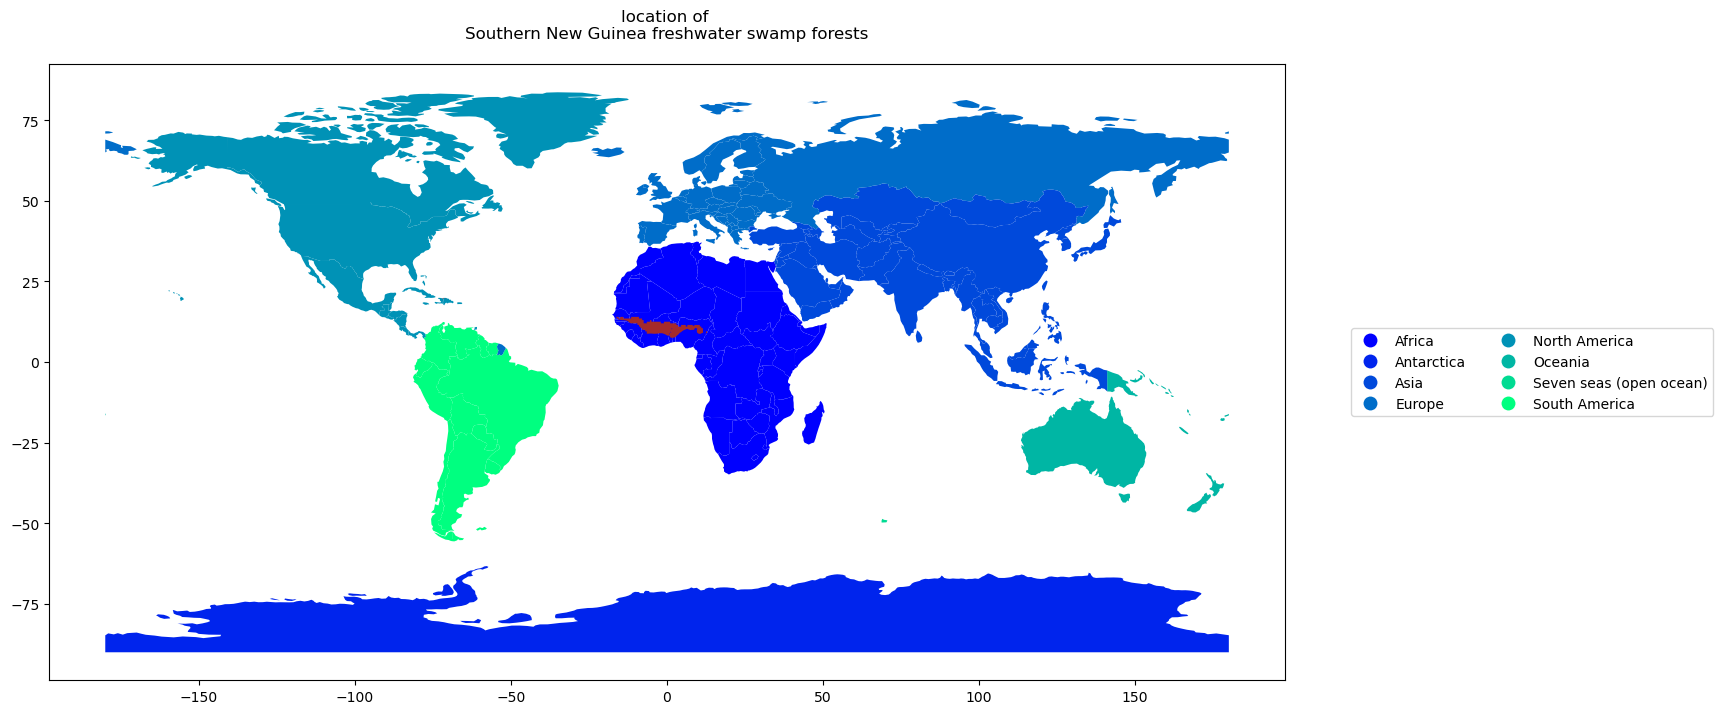

In [21]:
plot_within(world_data, 'continent', 'location of \nSouthern New Guinea freshwater swamp forests\n', 2)

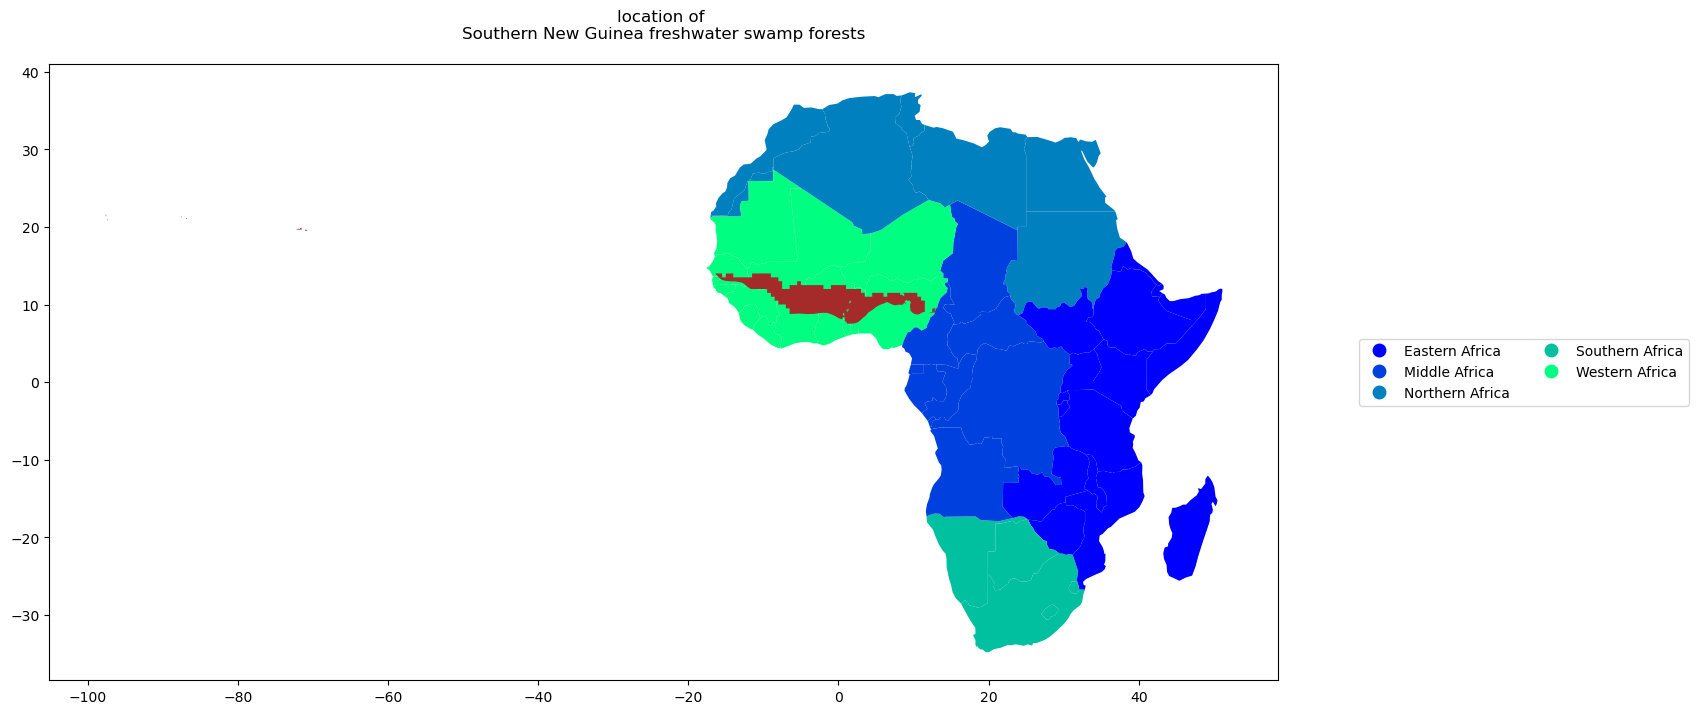

In [22]:
plot_within(continent, 'subregion', 'location of \nSouthern New Guinea freshwater swamp forests\n', 2)

##### climate

<b>A1F1

In [34]:
def climate_shifts(year, scenario):
    replace = {
    11: 'Af', 12 :'Am', 13 : 'As', 14 : 'Aw', 21 : 'BWk', 22 : 'BWh', 26 : 'BSk', 27 : 'BSh',
    31 : 'Cfa', 32 : 'Cfb', 33 : 'Cfc', 34 : 'Csa', 35 : 'Csb', 36 : 'Csc', 37 : 'Cwa', 38 : 'Cwb', 
    39 : 'Cwc', 41 : 'Dfa', 42 : 'Dfb', 43 : 'Dfc', 44 : 'Dfd', 45 : 'Dsa', 46 : 'Dsb', 47 :'Dsc', 
    48 :'Dsd', 49 : 'Dwa', 50 : 'Dwb', 51 : 'Dwc', 52 : 'Dwd', 61 : 'EF', 62 :'ET',
    }
    clim_shift = Read(f'data/climate/KoppenGeigerClimateShifts/{year}-{scenario}.geojson')
    clim_shift = clim_shift.wrangle(replace_values = True,
               column_to_replace= 'gridcode', replacing_values = replace)
    forest_clim_shift = gpd.clip(clim_shift, fav_forest)
    return forest_clim_shift

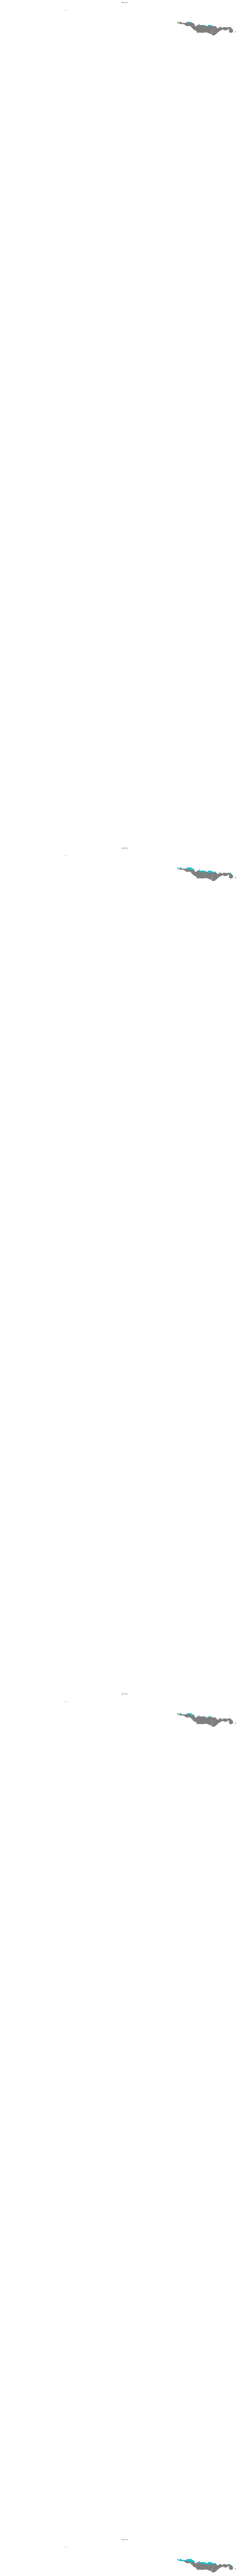

In [65]:
fig, ax = plt.subplots(nrows = 4, ncols = 1, figsize = (15,200))
years = ['2001-2025', '2026-2050', '2051-2075', '2076-2100']
for i in range(len(years)):
    climate_shifts(years[i], 'A1FI').plot(column = 'gridcode', ax = ax[i])
    ax[i].set_title(years[i], fontdict = {'fontsize': 4})
for ax in ax.flat:
    ax.axis('off')
#plt.suptitle('Koppen Geiger Climate shifts (worst case scenario)')

In [28]:
def region_tiff(data_path, title):
    path = data_path
    tiff_data = rxr.open_rasterio(path, masked=True).squeeze()
    clipped = tiff_data.rio.clip(continent.geometry.apply(mapping),
                                      # This is needed if your GDF is in a diff CRS than the raster data
                                      continent.crs)
    f, ax = plt.subplots(figsize=(10, 4))
    clipped.plot(ax=ax)
    fav_forest.plot(ax = ax , color = 'red')
    ax.set(title= title)
    ax.set_axis_off()
    plt.show()

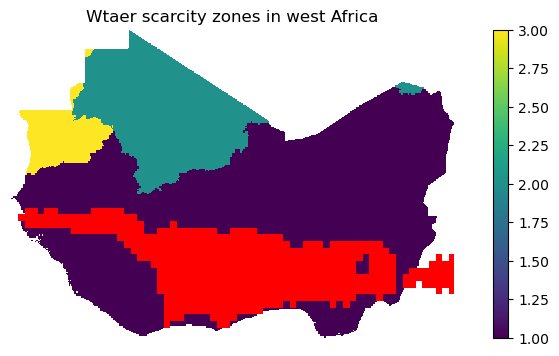

In [29]:
path = r'data/Bioclimatic and ecological zones/WaterScarcity_GAEZ.tif'
region_tiff(path, 'Water scarcity zones in west Africa')

In [ ]:
path = r'data/Bioclimatic and ecological zones/S40W060_agb.tif'
region_tiff(path, 'Water scarcity zones in west Africa')